<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

# Table of Contents
 <p><div class="lev1"><a href="#Introduction"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev2"><a href="#Purpose"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Purpose</a></div><div class="lev2"><a href="#Prior-work/-previous-next-steps"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prior work/ previous next steps</a></div><div class="lev2"><a href="#Guiding-questions"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Guiding questions</a></div><div class="lev2"><a href="#Key-findings"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Key findings</a></div><div class="lev2"><a href="#Related-notebooks"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Related notebooks</a></div><div class="lev1"><a href="#A.-Setup"><span class="toc-item-num">2&nbsp;&nbsp;</span>A. Setup</a></div><div class="lev2"><a href="#Required-packages"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Required packages</a></div><div class="lev2"><a href="#Data-input"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data input</a></div><div class="lev1"><a href="#B.-Explore"><span class="toc-item-num">3&nbsp;&nbsp;</span>B. Explore</a></div><div class="lev2"><a href="#Shape"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Shape</a></div><div class="lev2"><a href="#Visualize"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visualize</a></div><div class="lev1"><a href="#C.-Motion-detection"><span class="toc-item-num">4&nbsp;&nbsp;</span>C. Motion detection</a></div><div class="lev2"><a href="#1.-Convert-each-frame-to-gray-scale"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>1. Convert each frame to gray scale</a></div><div class="lev2"><a href="#2.-Smooth-each-frame"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>2. Smooth each frame</a></div><div class="lev2"><a href="#3.-Create-model-of-background"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>3. Create model of background</a></div><div class="lev2"><a href="#4.-Calculate-the-difference"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>4. Calculate the difference</a></div><div class="lev2"><a href="#5.-Threshold-the-difference"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>5. Threshold the difference</a></div><div class="lev1"><a href="#D1-Train-detection"><span class="toc-item-num">5&nbsp;&nbsp;</span>D1 Train detection</a></div><div class="lev1"><a href="#D2-Direction-detection"><span class="toc-item-num">6&nbsp;&nbsp;</span>D2 Direction detection</a></div><div class="lev1"><a href="#Conclusions"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusions</a></div><div class="lev2"><a href="#Key-findings"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Key findings</a></div><div class="lev2"><a href="#Next-steps"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Next steps</a></div>

# Introduction

## Purpose

The purpose of this work is to understand whether it would be possible to use video feed of the Caltrain tracks to detect when the Caltrain is passing and in what direction. We will use a test video clip that would be similar to that would be taken in real-time if we set up a permanent feed. If we can develop an algorithm that works for this test clip, it will provide support for moving forward and investing more resources in developing an IoT device for performing real-time train detection that will generate data that will be used in the improved prediction of Caltrain delays. 

## Prior work/ previous next steps

In the previous sprint, we attempted detecting a train in individual images using image classification techniques. While the precision was fairly high (~75%), this method did not use the added information of a train existing for many frames and we hypothesize that we can do better using motion detection techniques. Additionally, direction detection proved not viable using this method.

## Guiding questions
1. Can we detect that a train is passing in the test video? 
2. Can we identify in what direction the train is moving in the test video? 

## Key findings

* We were able to develop a proof of concept algorithm that can detect a train's passing and its direction from video. 
* The final algorithm depends on five parameters:
    * `k` : Size of the kernel used for Gaussian blur.
    * `alpha` : How heavily to weigh each new frame in running average.
    * `motion_thresh`: Minimum difference between the running average and new frame for a pixel to be considered in motion. 
    * `roi_thresh` : Minimum fraction of ROI that must be "in motion" to be considered train-like.
    * `history_length` : Number of frames in motion required to be considered a train.
* These parameters are likely affected by the environment and camera settings. This issue should be addressed in the next steps.
    

## Related notebooks

* **Copied from:** N/A
* **Purpose of copy:** N/A 
* **Copied to:** `2016-07-11-cmm-data-day-seattle-demo-2.ipynb`
* **Purpose of copy:** Test effects of different motion detection step.
* **Related notebooks:** `2016-07-11-cmm-data-day-seattle-talk.ipynb`

Prefix for saved files: 

In [14]:
pre = '2016-07-23-data-day-seattle-demo-'

# A. Setup

## Required packages

In [ ]:
%matplotlib inline
import sys
sys.path.remove('/Library/Python/2.7/site-packages')
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import cv2 #OpenCV

In [5]:
# %install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information
%version_information numpy, matplotlib, pandas, cv2

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 2.7.12 64bit [GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]
IPython 4.2.0
OS Darwin 15.5.0 x86_64 i386 64bit
numpy 1.11.0
matplotlib 1.5.1
pandas 0.15.1
cv2 3.1.0
Mon Jul 11 15:20:37 2016 PDT

Note, installed OpenCV (`cv2`) via:

`conda install -c https://conda.binstar.org/menpo opencv3`.

In [11]:
colors = ['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', 
          '#D34100', '#FF9700', '#091D32']
mpl_update = {'font.size':16,'xtick.labelsize':14,'ytick.labelsize':14,
              'figure.figsize':[12.0,8.0],
              'axes.labelsize':20,'axes.labelcolor':'#677385',
              'axes.titlesize':20,'lines.color':'#0055A7',
              'lines.linewidth':3,'text.color':'#677385'}
mpl.rcParams.update(mpl_update)

## Data input

* **File:** `data/test.mp4`
* **Description of data:** Video of Caltrain passing
* **Date range covered by data:** ~8 seconds on July 23, 2015
* **Included population:** N/A
* **Associated query file:** N/A
* **Associated query:** N/A

In [4]:
"""Here we load the video clip from an mp4 into a list of 
images to be used for the demonstration of the algorithm."""

# Load the video as a series of frames using the helper function in trainspotting.py
video_file = cv2.VideoCapture('data/test.mp4')

# Read iterates through the frames in the video object and returns:
# 1. Logical - True if a frame has been read
# 2. Image - an array with the current frame
read_file, frame = video_file.read()
original = []
while read_file:
    # Going to grab the frame and create a list for future use 
    original.append(frame)
    
    # Use imshow to play video
    cv2.imshow('Original video',frame)
    
    # Get next frame 
    read_file, frame = video_file.read()
    
    # Pause and allow for "q" button to stop video
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cv2.destroyWindow('Original video')

# B. Explore

## Shape

In [8]:
len(original)

162

The video is 162 frames long. 

In [9]:
original[0].shape

(480, 640, 3)

Each frame is 480 x 640 pixels with three color channels (red, green, blue).

## Visualize

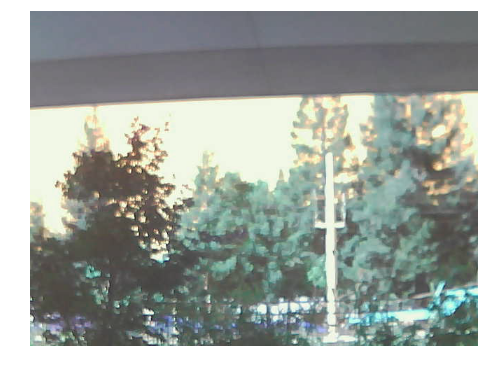

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(original[0]);
plt.axis('off');

It seems like I might want to do this again so I'm going to functionalize it. 

In [49]:
def plot_frame(frame, title='', new=True):
    if new:
        fig, ax = plt.subplots(figsize=(8,6))
    if len(frame.shape) == 2:
        plt.imshow(frame, cmap='Greys_r');
    else:
        plt.imshow(frame);
    plt.axis('off');
    plt.title(title);

Now, let's look at the whole video.

In [30]:
for j, frame in enumerate(original):
    
    cv2.imshow('Original video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cv2.destroyWindow('Original video')

# C. Motion detection

The plan for detecting where motion is in the frame is to:
1. Convert each frame to gray scale
2. Smooth each frame
3. Create the model of the background via a running average
4. Calculate the difference between the current frame and the background model
5. Threshold the difference to decide which pixels are in motion

## 1. Convert each frame to gray scale

In [8]:
for j,frame in enumerate(original):
    
    # Convert frame to gray_scale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    cv2.imshow('Gray scale',gray_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cv2.destroyWindow('Gray scale')

## 2. Smooth each frame

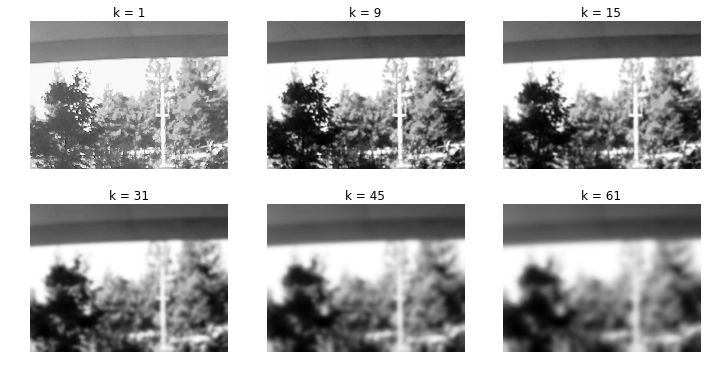

In [52]:
gray_frame = cv2.cvtColor(original[0], cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(2, 3, figsize=(12,6))

for j, k in enumerate([1, 9, 15, 31, 45, 61]):
    plt.subplot(2, 3, j+1)
    plot_frame(cv2.GaussianBlur(gray_frame, (k, k), 0), title='k = '+str(k), new=False)

<div class="alert alert-info"> Defining Gaussian kernel size, <code>k</code> </div>

In [5]:
k = 31 # Define Gaussian kernel size

In [14]:
for j, frame in enumerate(original):
    
    gray_frame = cv2.cvtColor(frame, cv2.
                              COLOR_BGR2GRAY)
    
    # Apply a Gaussian blur to the gray scale frame 
    smooth_frame = cv2.GaussianBlur(gray_frame, (k, k), 0)
    
    cv2.imshow('Smooth', smooth_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
        
cv2.destroyWindow('Smooth')

## 3. Create model of background

While more complex methods can require fitted statistical models for each pixel, frame differencing simply requires a representative image as the background model. Basic options for this representative model include a stationary image deemed as background by the user and the average of the last *n* images. In our POC, we employ a running average, which is still simple to implement and requires minimal computation but also is able to adapt to changing conditions over time. The running average is calculated for a given pixel (*x*,*y*) at each time, *t* as:
\begin{equation}
R(x,y,t) = (1-\alpha)R(x,y,t-1) + \alpha F(x,y,t)
\end{equation}
The value $\alpha$ adjusts the weight of the current frame being averaged in and regulates the speed at which the previous frames are forgotten.

To update the running average in Python, we use the function: 
<center>
<code>
cv2.accumulateWeighted(np.float32(smooth_frame), running_avg, alpha)
</code>
</center>

Since we are summing fractions of images, we need to be able to hold float values for the pixels, which requires us to convert the smooth frame that we are updating the running average with to float values. 


<div class="alert alert-info"> Defining weighting coefficient for running average, <code>alpha</code> </div>

In [8]:
alpha = 0.2

In [11]:
running_avg = None # Define variable for running average
for j, frame in enumerate(original):
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(gray_frame, (k, k), 0)
    
    # If this is the first frame, making running avg current frame
    # Otherwise, update running average with new smooth frame
    if running_avg is None:
        running_avg = np.float32(smooth_frame) 
    else:
        cv2.accumulateWeighted(np.float32(smooth_frame), running_avg, alpha)
    
    cv2.imshow('Running average', cv2.convertScaleAbs(running_avg))

    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cv2.destroyWindow('Running average')

## 4. Calculate the difference

To detect areas of change between the current frame and the current model of the background, we take the absolute difference between the pixel values of the two frames (i.e. `|smooth_frame - running_avg|`) using the [`cv2.absdiff()`](http://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#absdiff) function:

diff = cv2.absdiff(np.float32(smooth_frame), running_avg)

Again, we must covert `smooth_frame` to float values to perform mathematical operations with the pixel values. This step is actually performed *before* updating the background model as we are trying to compare the new frame to our already existing model of the background. Performing this for each incoming frame, we get as output the following video:


In [10]:
running_avg = None 

for j, frame in enumerate(original):

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(gray_frame, (k, k), 0)
    
    # If this is the first frame, making running avg current frame
    if running_avg is None:
        running_avg = np.float32(smooth_frame) 
        
    # Find |difference| between current smoothed frame and running average
    diff = cv2.absdiff(np.float32(smooth_frame), np.float32(running_avg))
    
    # Then add current frame to running average after
    cv2.accumulateWeighted(np.float32(smooth_frame), running_avg, alpha)

    cv2.imshow('Difference', diff)

    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cv2.destroyWindow('Difference')

## 5. Threshold the difference

As we see in the above video, we detect variations in pixel values in locations and at times other than where and when the train is passing, such as when leaves are rustling. One way to remove some of the small-scale movements is to count only large fluctuations in pixel values as motion. We do this by setting a threshold value and setting all differences higher than this value as motion using the [`cv2.threshold()`](http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?highlight=threshold#threshold) function:
<center><code>_, subtracted = cv2.threshold(diff, motion_thresh, 1, cv2.THRESH_BINARY)</code></center>
<br />



This function sets any value in `diff` that is greater than `motion_thresh` to 1 and leaves all other pixels as zero. Applying this function to the prior video of differences using a threshold of 35, we get the following video, where white area denotes motion (`diff > 35`) and black area is considered stationary (`diff <=35`):

<div class="alert alert-info"> Defining threshold for considering a pixel in motion, <code>motion_thresh</code> </div>

In [6]:
# All pixels with differences above this value will be set to 1
motion_thresh = 35 

In [12]:
running_avg = None 
for j, frame in enumerate(original):
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(gray_frame, (k, k), 0)
    
    if running_avg is None:
        running_avg = np.float32(smooth_frame) 
    
    diff = cv2.absdiff(np.float32(smooth_frame), np.float32(running_avg))
    
    cv2.accumulateWeighted(np.float32(smooth_frame), running_avg, alpha)
    
    # For all pixels with a difference > thresh, turn pixel to 1, otherwise 0
    _, subtracted = cv2.threshold(diff, motion_thresh, 1, cv2.THRESH_BINARY)
    
    cv2.imshow('Thresholded difference', subtracted)
    
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cv2.destroyWindow('Thresholded difference')

# D1 Train detection

Now that we have identified where there is motion in the frame, we now need to figure out if that motion is in fact a train. Two questions that can help us figure out if the motion is in fact a train and not a person or car are: 
1. Is enough of the frame in motion? 
2. Does this motion last as long as a train? 

To consider the first question, we can look at the fraction of each frame that is in motion, $\frac{\textrm{number of pixels in motion}}{\textrm{total number of pixels}}$ as shown in the following video alongside the thresholded video: 

In [9]:
# Initialize list for capturing fraction of each frame in motion 
motion_fractions = [] 

running_avg = None
for j, frame in enumerate(original):
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(gray_frame, (k, k), 0)
    
    if running_avg is None:
        running_avg = np.float32(smooth_frame) 
    
    diff = cv2.absdiff(np.float32(smooth_frame), np.float32(running_avg))
    cv2.accumulateWeighted(np.float32(smooth_frame), running_avg, alpha)
    _, subtracted = cv2.threshold(diff, motion_thresh, 1, cv2.THRESH_BINARY)
    
    # Calculate the fraction of pixels where motion is detected
    # i.e. where subtracted==1
    motion_fraction = (sum(sum(subtracted))/
                       (subtracted.shape[0]*subtracted.shape[1]))

    motion_fractions.append(motion_fraction)
    

We can see that despite only the windows being in motion for a majority of the train's length, we still see a clear portion of the frame in motion. 

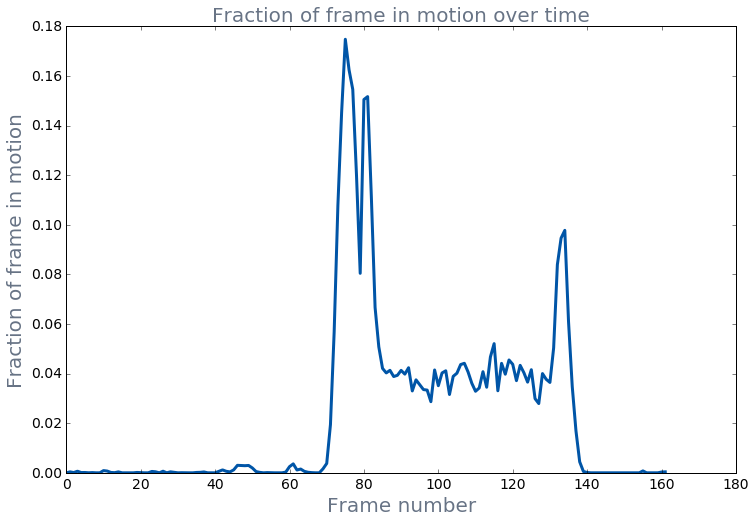

In [15]:
plt.plot(motion_fractions, color=colors[0]);
plt.xlabel('Frame number');
plt.ylabel('Fraction of frame in motion');
plt.title('Fraction of frame in motion over time');
plt.savefig(pre + 'fraction-frame-in-motion.png')

By setting a threshold for how much of the frame must be in motion, we can say "whatever is in the frame is *large* enough to be a train," such as by the horizontal line in the following figure: 

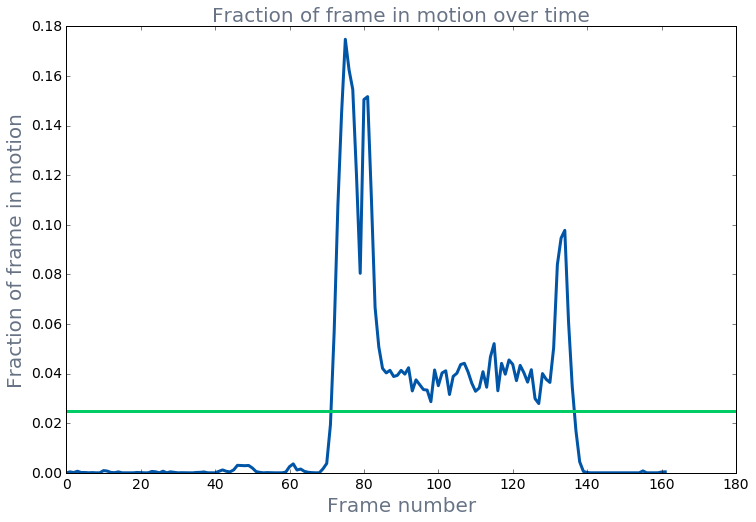

In [70]:
plt.plot(motion_fractions, color=colors[0]);
plt.axhline(y=0.025, color=colors[3]);
plt.xlabel('Frame number');
plt.ylabel('Fraction of frame in motion');
plt.title('Fraction of frame in motion over time');

Now that we have identified there is enough motion to be a train, we must determine if the motion lasts long enough to be considered a train so that we do not count any pedestrians or cars passing by. We see in the following figure that at the current frame rate (e.g. number of images per second), a train lasts for approximately 70 frames. 

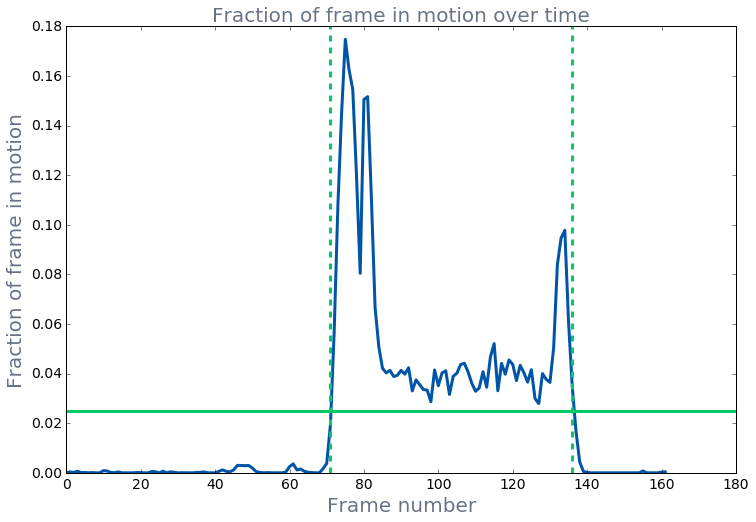

In [71]:
plt.plot(motion_fractions, color=colors[0]);
plt.axhline(y=0.025, color=colors[3]);
plt.axvline(x=71, color=colors[3], linestyle='--');
plt.axvline(x=136, color=colors[3], linestyle='--');
plt.xlabel('Frame number');
plt.ylabel('Fraction of frame in motion');
plt.title('Fraction of frame in motion over time');

Thus, by applying required thresholds in fraction of frame in motion and number of frames where that threshold is met, we can detect that a train passes. 

<div class="alert alert-info"> Defining minimum fraction of the frame required to be in motion to be considered train size, <code>frame_thresh</code> </div>

In [ ]:
frame_thresh = 0.025

<div class="alert alert-info"> Defining number of frames to be considered long enough to be a train, <code>history_length</code> </div>

In [76]:
history_length = 50

In [77]:
# Initialize dataframe to capture motion
history = pd.DataFrame(data=[[0,0]], columns=['Fraction','In_motion'])
running_avg = None 

for j, frame in enumerate(original):
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(gray_frame, (k, k), 0)
    
    if running_avg is None:
        running_avg = np.float32(smooth_frame) 
    
    diff = cv2.absdiff(np.float32(smooth_frame), np.float32(running_avg))
    cv2.accumulateWeighted(np.float32(smooth_frame), running_avg, alpha)
    
    _, subtracted = cv2.threshold(diff, motion_thresh, 1, cv2.THRESH_BINARY)
    
    motion_fraction = (sum(sum(subtracted))/
                       (subtracted.shape[0]*subtracted.shape[1]))
    
    history.loc[len(history)+1] = [motion_fraction, motion_fraction>frame_thresh]
    
    detect = (history.tail(history_length).In_motion.sum()==history_length)
    
    if detect: 
        print 'Train detected beginning at frame', j-history_length
        # Reset history
        history = pd.DataFrame(data=[[0,0]],columns=['Fraction','In_motion']) 

Train detected beginning at frame 71


# D2 Direction detection

The prior method does not tell us in what direction the train is moving. For that piece of the problem, we have to extend the algorithm. We see in the image below that when the train first enters the frame, it is only present on one side. If the train is south-bound (such as in the figure), the train will first only be present in the left half of the frame versus the right side if north-bound. 

There are a number of ways we can use these two streams of data (fraction of motion in left ROI and fraction of motion in right ROI) to determine that a train is passing and in what direction it is going. In this POC, we simply track whether each ROI has detected the required fraction of motion in a dataframe (see below) and when one ROI has met this threshold for enough frames to be considered a train, we identify which ROI has detected motion longer. Within the algorithm, the steps are as follows: 

1. Initialize a dataframe, `history`.
2. At each frame, *t*, add row to dataframe indicating if left and/or right meets motion threshold.
3. Repeat #2 until motion threshold met on either side for last *T* frames.
3. The side with the detection for all *T* indicates the train's direction.
4. Reinitialize the `history` dataframe to detect future trains.
5. Return to #2.     

<div class="alert alert-info"> Defining fraction of ROI required to be considered in motion, `roi_thresh` </div>

In [78]:
roi_thresh = 0.05 

In [79]:
history = pd.DataFrame(columns=['Detected left','Detected right'])
running_avg = None 
for j, frame in enumerate(original):

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(gray_frame, (k, k), 0)
    
    if running_avg is None:
        running_avg = np.float32(smooth_frame) 
    
    diff = cv2.absdiff(np.float32(smooth_frame), np.float32(running_avg))
    cv2.accumulateWeighted(np.float32(smooth_frame), running_avg, alpha)
    _, subtracted = cv2.threshold(diff, motion_thresh, 1, cv2.THRESH_BINARY)

    left_area = subtracted[270:400,240:340] 
    right_area = subtracted[270:400,540:640] 
    
    left_fraction = sum(sum(left_area))*1.0/(left_area.shape[0]*left_area.shape[1])
    right_fraction = sum(sum(right_area))*1.0/(right_area.shape[0]*right_area.shape[1])
    
    # Update the history with whether the train detection criteria was met on either side
    history.loc[len(history)+1] = [left_fraction>roi_thresh, right_fraction>roi_thresh]
    
    # Get how many of last n frames had a train detected for left and right ROIs
    left_cum, right_cum = history.tail(history_length).sum()
    
    # If all of last n frames had train detected on at least one side
    if left_cum >= history_length or right_cum >= history_length: 
        
        # If a train was detected longer on the left, then it is south bound
        if left_cum > right_cum:
            print 'South bound train beginning at frame', j-history_length
        else: 
            print 'North bound train beginning at frame', j-history_length
        
        train = history.tail(history_length).head(10)
        
        # Reset the history to be able to detect a new train
        history = pd.DataFrame(columns=['Detected left','Detected right'])

South bound train beginning at frame 71


<div class="alert alert-warning"> Moving to a function in <code>../src/detect_train_direction.py</code>
 </div>

# Conclusions

## Key findings

* We were able to develop a proof of concept algorithm that can detect a train's passing and its direction from video. 
* The final algorithm depends on five parameters:
    * `k` : Size of the kernel used for Gaussian blur.
    * `alpha` : How heavily to weigh each new frame in running average.
    * `motion_thresh`: Minimum difference between the running average and new frame for a pixel to be considered in motion. 
    * `roi_thresh` : Minimum fraction of ROI that must be "in motion" to be considered train-like.
    * `history_length` : Number of frames in motion required to be considered a train.
    

## Next steps

* This POC shows that we would likely be successful in detecting trains and their direction if deployed and used in real-time. However, we may want to iterate on it to optimize for applicability across different times of days and under different edge cases. There may be  The `motion_thresh` and `roi_thresh` will likely change with the environment. We may want to adjust the algorithm used for motion detection to something that is more robust. 
* Additionally, if we would like to deploy on a Raspberry Pi or similar, we may have to make adjustments in frame rate (number of images taken per second) and resolution, which would change the `alpha`, `roi_thresh`, and `history_length` parameters.     